In [1]:
from datahandler import *
from playground import *
from gui import *
from torchutils import *
from models import *
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

C:\Users\Alexis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
seq_length = 15

In [4]:
minute = True
hour = False

In [5]:
data = None
idx_skip = 0
if minute:
    idx_skip = int(seq_length)
    data = pd.read_csv("BTCUSDT_15m.csv")
    data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)

elif hour:
    idx_skip = int(seq_length / 3)
    data = pd.read_csv("BTCUSDT_1h.csv")
    data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)

else:
    idx_skip = int(seq_length / 3)
    if not os.path.exists('./BTCUSDT_DB.csv'):
        data = pd.read_csv("BTCUSDT_1m.csv")
        data = get_dollar_bars(data)
        data.to_csv('./BTCUSDT_DB.csv', sep=',')
    else:
        data = pd.read_csv('./BTCUSDT_DB.csv', sep=',')

handler = NewDataHandler(dataset=data)

In [6]:
data

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades
0,1502942400000,4261.48,4280.56,4261.48,4261.48,2.189061,9.333621e+03,9
1,1502943300000,4261.48,4270.41,4261.32,4261.45,9.119865,3.889113e+04,40
2,1502944200000,4280.00,4310.07,4267.99,4310.07,21.923552,9.408092e+04,58
3,1502945100000,4310.07,4313.62,4291.37,4308.83,13.948531,6.006047e+04,64
4,1502946000000,4308.83,4328.69,4304.31,4304.31,5.101153,2.200653e+04,44
...,...,...,...,...,...,...,...,...
193435,1677537900000,23397.31,23557.79,23390.54,23482.13,3276.986710,7.697566e+07,118924
193436,1677538800000,23481.28,23508.27,23448.20,23467.31,2209.161100,5.187482e+07,84221
193437,1677539700000,23467.89,23525.88,23466.17,23490.51,1624.076700,3.816044e+07,74878
193438,1677540600000,23491.18,23555.24,23480.79,23534.67,1677.606430,3.944878e+07,81570


In [7]:
agent_horizon = 4
crossover_horizon = 3
crossover_lag_horizon = 1

In [8]:
ma1, ma2, ma_mode = 5, 10, 'normal'
ma_modes = {'exponential': 'EMA', 'normal': 'MA'}
ma_name = ma_modes[ma_mode]
k1, k2 = 10, 30
handler.data = ma_crossover_labelling(handler.data, ma1, ma2, crossover_horizon, ma_mode)
handler.data.rename({'Label': 'Crossover'}, axis=1, inplace=True)
dummies = pd.get_dummies(handler.data['Crossover'], prefix='Crossover') * 1
handler.data.drop('Crossover', axis=1, inplace=True)
handler.data = pd.concat([handler.data, dummies], axis=1)

handler.data = ma_crossover_lagging_labelling(handler.data, ma1, ma2, crossover_lag_horizon, ma_mode)
cross_lag_dummies = pd.get_dummies(handler.data[f'Crossover_Lag_{crossover_lag_horizon}'], prefix=f'Crossover_Lag_{crossover_lag_horizon}_') * 1
handler.data.drop(f'Crossover_Lag_{crossover_lag_horizon}', axis=1, inplace=True)
handler.data = pd.concat([handler.data, cross_lag_dummies], axis=1)

handler.data = triple_barrier_labelling(handler.data, upper_barrier=1.005, lower_barrier=0.995, time_limit=agent_horizon)
handler.data = add_kendall_tau(handler.data, k1)
handler.data = add_kendall_tau(handler.data, k2)
handler.data = add_ichimoku(handler.data)
ichimoku_cols = ['ABOVE_ICHIMOKU_9', 'ABOVE_ICHIMOKU_26', 'Close_ICHIMOKU_9_PERC_DIFF', 'Close_ICHIMOKU_26_PERC_DIFF']

handler.add_indicators([Indicators.RSI, Indicators.MACD,
                       Indicators.ADX, Indicators.OBV, Indicators.NTRADES])

handler.create_var_indicator([Indicators.RSI, Indicators.MACD, Indicators.ADX, Indicators.OBV, Indicators.LOG_RET, Indicators.NTRADES])

# display(handler.data[handler.data.isnull().any(axis=1)]) # Displaying all the rows that contain missing values to see if they are spread across the dataframe

handler.data.replace([np.inf, -np.inf], 0, inplace=True)

# handler.standardize_data()

handler.data.dropna(axis=0, inplace=True)

handler.create_predict_data()

predict_data = handler.predict_data
predict_data['Target'] = handler.data['Label']
predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
predict_data[f'{ma_name}{ma1} Var'], predict_data[f'{ma_name}{ma2} Var'] = handler.data[f'{ma_name}{ma1} Var'], handler.data[f'{ma_name}{ma2} Var']
# predict_data[dummies.columns] = handler.data[dummies.columns]
predict_data[f'Close_{ma_name}{ma1}_PERC_DIFF'], predict_data[f'Close_{ma_name}{ma2}_PERC_DIFF'] = handler.data[f'Close_{ma_name}{ma1}_PERC_DIFF'], handler.data[f'Close_{ma_name}{ma2}_PERC_DIFF']
predict_data[f'{ma_name}{ma1} UP'], predict_data[f'{ma_name}{ma2} UP'] = (handler.data[f'{ma_name}{ma1}'] > handler.data[f'{ma_name}{ma2}']) * 1, (handler.data[f'{ma_name}{ma1}'] < handler.data[f'{ma_name}{ma2}']) * 1
predict_data[cross_lag_dummies.columns] = handler.data[cross_lag_dummies.columns]
predict_data[ichimoku_cols] = handler.data[ichimoku_cols]
predict_data.reset_index(drop=True, inplace=True)

C:\Users\Alexis\AppData\Local\Temp\ipykernel_28040\3888746182.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Target'] = handler.data['Label']
C:\Users\Alexis\AppData\Local\Temp\ipykernel_28040\3888746182.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
C:\Users\Alexis\AppData\Local\Temp\ipykernel_28040\3888746182.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [9]:
add_percent_return(handler.data, agent_horizon)['PERC_RET'].abs().describe()

count    193311.000000
mean          0.005199
std           0.007361
min           0.000000
25%           0.001236
50%           0.002931
75%           0.006253
max           0.296093
Name: PERC_RET, dtype: float64

In [10]:
handler.data

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades,MA5,MA10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,Crossover_-1,Crossover_0,Crossover_1,EMA5,EMA10,Crossover_Lag_1__-1,Crossover_Lag_1__0,Crossover_Lag_1__1,Label,Index,Kendall_10,Kendall_30,ICHIMOKU_9,ICHIMOKU_26,ABOVE_ICHIMOKU_9,ABOVE_ICHIMOKU_26,Close_ICHIMOKU_9_PERC_DIFF,Close_ICHIMOKU_26_PERC_DIFF,RSI,RSI_30-,RSI_BTW,RSI_70+,MACD,MACD_H,ADX14,+DM,-DM,OBV,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,LOG_RET,NTrades Var
78,1503012600000,4327.89,4332.26,4314.13,4328.25,10.899352,4.713084e+04,59,4333.718,4336.643,0.000090,-0.000914,0.001263,0.001939,0,1,0,4330.622897,4330.919326,1,0,0,-1.0,79.0,-0.377778,0.172414,4366.7025,4370.345,0,0,0.008884,0.009726,48.882487,0,1,0,-2.120408,2.847985,38.787777,12.948911,25.786021,-0.116491,0.001621,0.020591,-0.209500,-0.011171,-0.000886,-0.032114,-0.367828,0.000083,-0.144928
79,1503013500000,4325.82,4332.26,4280.82,4285.08,31.408662,1.349674e+05,89,4320.266,4330.218,-0.003104,-0.001482,0.008211,0.010534,0,1,0,4315.441932,4322.584903,0,1,0,1.0,81.0,-0.466667,0.108046,4366.7025,4370.345,0,0,0.019048,0.019898,40.750486,0,1,0,-5.573522,-0.484104,39.059475,11.791830,29.268193,0.379952,-0.166358,1.628514,-1.169981,0.007005,0.135041,-0.089357,-4.261652,-0.010024,0.508475
80,1503014400000,4285.08,4305.76,4267.78,4305.76,10.458487,4.480521e+04,58,4314.058,4325.359,-0.001437,-0.001122,0.001927,0.004552,0,1,0,4312.214621,4319.525829,0,1,0,0.0,83.0,-0.422222,0.071264,4360.2225,4370.345,0,0,0.012649,0.015000,45.433479,0,1,0,-6.565751,-1.181066,39.543175,11.009589,29.604236,-0.091682,0.114919,0.178025,1.439696,0.012384,0.011482,-0.066338,-1.241299,0.004814,-0.348315
81,1503015300000,4309.08,4309.92,4285.85,4292.11,15.912984,6.836449e+04,54,4307.818,4321.215,-0.001446,-0.000958,0.003660,0.006781,0,1,0,4305.513081,4314.541133,0,1,0,0.0,83.0,-0.511111,0.108046,4345.5300,4360.420,0,0,0.012446,0.015915,43.016670,0,1,0,-8.357204,-2.378015,39.793738,11.281316,28.321941,0.153578,-0.053194,0.272848,1.013448,0.006336,-0.043315,0.024681,-2.675116,-0.003175,-0.068966
82,1503016200000,4292.11,4309.15,4286.01,4302.15,12.542524,5.393592e+04,58,4302.670,4317.998,-0.001195,-0.000744,0.000121,0.003684,0,1,0,4304.392054,4312.288199,0,1,0,0.0,83.0,-0.511111,0.135632,4319.3975,4352.035,0,0,0.004009,0.011595,45.320634,0,1,0,-8.864613,-2.308340,40.026180,10.797128,27.106378,-0.104934,0.053560,0.060715,-0.029300,0.005841,-0.042919,-0.042919,-1.683261,0.002336,0.074074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193431,1677534300000,23379.88,23393.00,23358.80,23381.38,1430.712090,3.344707e+07,94794,23354.220,23306.523,0.001166,0.000273,-0.001162,-0.003202,0,1,0,23352.112641,23331.114052,0,1,0,1.0,193435.0,0.644444,-0.411494,23639.8075,23615.320,0,0,0.011053,0.010005,52.348672,0,1,0,-27.258362,19.520587,30.408179,18.071461,24.341552,0.006667,0.001017,-0.213901,0.149378,-0.038023,-0.025595,-0.025595,-0.354712,0.000024,-0.165560
193432,1677535200000,23381.38,23440.00,23361.26,23389.14,2391.775100,5.597601e+07,121312,23367.774,23316.546,0.000580,0.000430,-0.000914,-0.003104,0,1,0,23364.455094,23341.664225,0,1,0,1.0,193435.0,0.822222,-0.324138,23652.4550,23615.320,0,0,0.011258,0.009670,53.128114,0,1,0,-20.517560,21.009111,28.619911,20.555001,22.889001,0.011071,0.014889,-0.247293,0.076254,-0.058809,-0.059674,0.137429,0.660667,0.000332,0.279743
193433,1677536100000,23389.14,23422.78,23361.07,23379.54,1678.521720,3.925529e+07,91699,23376.312,23326.865,0.000365,0.000443,-0.000138,-0.002253,0,1,0,23369.483396,23348.550729,0,1,0,1.0,193435.0,0.822222,-0.241379,23652.4550,23615.320,0,0,0.011673,0.010085,51.995023,0,1,0,-15.768299,20.606698,26.961789,19.569391,21.806238,-0.007684,-0.021328,-0.231473,-0.019154,-0.057936,-0.047305,-0.047950,-1.694105,-0.000411,-0.244106
193434,167753700000

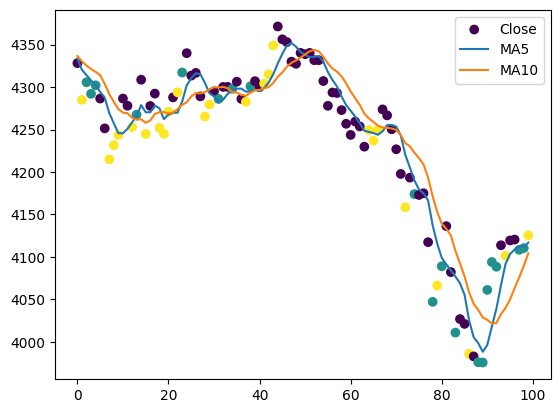

In [11]:
plt.scatter(range(100), handler.data['Close'][0:100], c=handler.data['Label'][0:100], label="Close")
plt.plot(range(100), handler.data[f'MA{ma1}'][0:100], label=f"MA{ma1}")
plt.plot(range(100), handler.data[f'MA{ma2}'][0:100], label=f"MA{ma2}")
plt.legend()
plt.show()

In [12]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,NTrades Var,RSI_30-,RSI_BTW,RSI_70+,LOG_RET,Target,Kendall_10,Kendall_30,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5 UP,MA10 UP,Crossover_Lag_1__-1,Crossover_Lag_1__0,Crossover_Lag_1__1,ABOVE_ICHIMOKU_9,ABOVE_ICHIMOKU_26,Close_ICHIMOKU_9_PERC_DIFF,Close_ICHIMOKU_26_PERC_DIFF
0,1503012600000,0.001621,0.020591,-0.209500,-0.011171,-0.000886,-0.032114,-0.367828,-0.144928,0,1,0,0.000083,-1.0,-0.377778,0.172414,0.000090,-0.000914,0.001263,0.001939,0,1,1,0,0,0,0,0.008884,0.009726
1,1503013500000,-0.166358,1.628514,-1.169981,0.007005,0.135041,-0.089357,-4.261652,0.508475,0,1,0,-0.010024,1.0,-0.466667,0.108046,-0.003104,-0.001482,0.008211,0.010534,0,1,0,1,0,0,0,0.019048,0.019898
2,1503014400000,0.114919,0.178025,1.439696,0.012384,0.011482,-0.066338,-1.241299,-0.348315,0,1,0,0.004814,0.0,-0.422222,0.071264,-0.001437,-0.001122,0.001927,0.004552,0,1,0,1,0,0,0,0.012649,0.015000
3,1503015300000,-0.053194,0.272848,1.013448,0.006336,-0.043315,0.024681,-2.675116,-0.068966,0,1,0,-0.003175,0.0,-0.511111,0.108046,-0.001446,-0.000958,0.003660,0.006781,0,1,0,1,0,0,0,0.012446,0.015915
4,1503016200000,0.053560,0.060715,-0.029300,0.005841,-0.042919,-0.042919,-1.683261,0.074074,0,1,0,0.002336,0.0,-0.511111,0.135632,-0.001195,-0.000744,0.000121,0.003684,0,1,0,1,0,0,0,0.004009,0.011595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193310,1677534300000,0.001017,-0.213901,0.149378,-0.038023,-0.025595,-0.025595,-0.354712,-0.165560,0,1,0,0.000024,1.0,0.644444,-0.411494,0.001166,0.000273,-0.001162,-0.003202,1,0,0,1,0,0,0,0.011053,0.010005
193311,1677535200000,0.014889,-0.247293,0.076254,-0.058809,-0.059674,0.137429,0.660667,0.279743,0,1,0,0.000332,1.0,0.822222,-0.324138,0.000580,0.000430,-0.000914,-0.003104,1,0,0,1,0,0,0,0.011258,0.009670
193312,1677536100000,-0.021328,-0.231473,-0.019154,-0.057936,-0.047305,-0.047950,-1.694105,-0.244106,0,1,0,-0.000411,1.0,0.822222,-0.241379,0.000365,0.000443,-0.000138,-0.002253,1,0,0,1,0,0,0,0.011673,0.010085
193313,1677537000000,0.037652,-0.337270,0.006464,-0.057106,-0.033850,-0.033850,-1.726043,-0.105301,0,1,0,0.000760,1.0,0.822222,-0.126437,0.000399,0.000737,-0.000499,-0.002276,1,0,0,1,0,0,0,0.006382,0.006382


In [13]:
dataset = TSDataset(predict_data, seq_length)

In [14]:
train_indices = range(0, round(0.7 * len(dataset)), idx_skip)
val_indices = range(round(0.7 * len(dataset)), round(0.9 * len(dataset)), idx_skip)
test_indices = range(round(0.9 * len(dataset)), len(dataset) - seq_length)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices) # Validation set will be training set for Meta Labelling
test_set = torch.utils.data.Subset(dataset, test_indices)

In [15]:
label_distribution = (predict_data.loc[train_set.indices, 'Target'].value_counts() / predict_data.loc[train_set.indices, 'Target'].shape[0]).sort_index().to_list()
display(predict_data.loc[train_set.indices, 'Target'].value_counts())
label_distribution

Target
 0.0    3593
-1.0    2805
 1.0    2623
Name: count, dtype: int64

[0.3109411373461922, 0.39829287218711895, 0.29076599046668883]

In [16]:
class_weights = [1 / p for p in label_distribution]
print(class_weights)
# class_weights = [4, 1, 4]
weights = [class_weights[torch.argmax(label)] for _, label in train_set]
train_sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_set), replacement=True)
# train_sampler = None

[3.216042780748663, 2.5107152797105483, 3.4391917651544035]


In [17]:
input_size = dataset.size
hidden_size = 500
batch_size = 32
num_layers = 1
output_size = predict_data['Target'].unique().size
lstm_model = LSTMModel(input_size, hidden_size,
                       num_layers, output_size).to(device)

In [18]:
weights = torch.Tensor(label_distribution).to(device)
losses, accuracies, val_losses, val_accuracies, _, _ = train_lstm(lstm_model, train_set, val_set, 30, 0.00001,
           batch_size, num_layers, hidden_size, device, train_sampler, class_weights=None, model_name=f'agent_{seq_length}_to_{agent_horizon}', save=True)

Epoch: 1/30 -- [8178/9021 (100.0%)]	Loss: 1.0986037102151425	Accuracy: 0.331	Time taken: 2.546875	Validation Loss: 1.0985336303710938 || Validation Accuracy: 0.339
Epoch: 2/30 -- [8178/9021 (100.0%)]	Loss: 1.09847946919448	Accuracy: 0.338	Time taken: 2.5	Validation Loss: 1.0984143018722534 || Validation Accuracy: 0.340
Epoch: 3/30 -- [8178/9021 (100.0%)]	Loss: 1.0984393776731287	Accuracy: 0.331	Time taken: 2.515625	Validation Loss: 1.0982929468154907 || Validation Accuracy: 0.339
Epoch: 4/30 -- [8178/9021 (100.0%)]	Loss: 1.0982432069507897	Accuracy: 0.348	Time taken: 2.46875	Validation Loss: 1.0981043577194214 || Validation Accuracy: 0.356
Epoch: 5/30 -- [8178/9021 (100.0%)]	Loss: 1.0981005252675806	Accuracy: 0.360	Time taken: 2.46875	Validation Loss: 1.0981945991516113 || Validation Accuracy: 0.349
Epoch: 6/30 -- [8178/9021 (100.0%)]	Loss: 1.0979926742560475	Accuracy: 0.362	Time taken: 2.421875	Validation Loss: 1.0981932878494263 || Validation Accuracy: 0.344
Epoch: 7/30 -- [8178/9021

In [19]:
# lstm_model = torch.load(f'./models/agent_{seq_length}_to_{agent_horizon}.pt').to(device)

In [20]:
eval_lstm(lstm_model, test_set, 64, num_layers, hidden_size, device)

Accuracy : 0.5213564587108465 || Loss : 1.059641718864441
Confusion matrix : 
[[ 436. 1925. 1224.]
 [1168. 8445. 2613.]
 [ 469. 1846. 1189.]]


(tensor([[0.4088, 0.0282, 0.5630],
         [0.4082, 0.0287, 0.5631],
         [0.3961, 0.0327, 0.5711],
         ...,
         [0.3071, 0.3367, 0.3562],
         [0.3009, 0.3553, 0.3437],
         [0.2999, 0.3720, 0.3281]], device='cuda:0', grad_fn=<CatBackward0>),
 tensor([[0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         ...,
         [0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.]], device='cuda:0'))

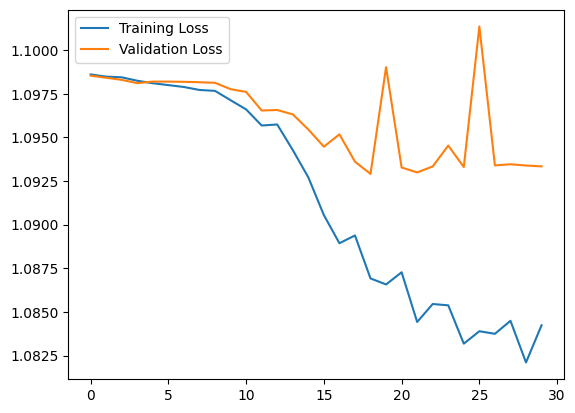

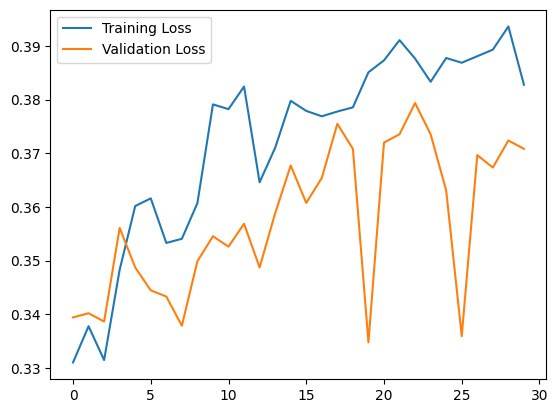

In [21]:
plt.plot([float(loss) for loss in losses], label="Training Loss")
plt.plot([float(loss) for loss in val_losses], label="Validation Loss")
plt.legend()
plt.show()
plt.plot([float(acc) for acc in accuracies], label="Training Loss")
plt.plot([float(acc) for acc in val_accuracies], label="Validation Loss")
plt.legend()
plt.show()